## SFD BMD 계산기

## 셋업

이 계산기는 정정 BEAM을 풀 수 있음. 부정정 구조물은 해석 불능.

In [1]:
# 라이브러리 불러오기
import math
import numpy as np

In [2]:
# EDIT 금지
pointLoads = np.array([[]]) # 점하중 : [location, xMag, yMag]
pointMoments = np.array([[]]) # 점모멘트 : [location, xMag, yMag]
disrtibutedLoads = np.array([[]])
linearLoads = np.array([[]])

In [3]:
# SPAN과 FORCE DATA 불러오기
span = 17 # 빔의 길이
A = 3
B = 13

# 하중 데이터
pointLoads = np.array([[6,0,-90]])
pointMoments = np.array([[17,50]]) #시계방향이 +값.

distributedLoads = np.array([[8,17,-10]])
linearLoads = np.array([[8,17,-10,0]])

In [4]:
divs = 10000 # 데이터를 얼마나 촘촘히 분석하는가?
delta = span/divs
X = np.arange(0,span+delta,delta) # x-축의 range
nPL = len(pointLoads[0]) # 집중하중
nPM = len(pointMoments[0]) # 점모멘트 개수
nUDL = len(distributedLoads[0])
nLDL = len(linearLoads[0])

reactions = np.array([0.0,0,0]) #반력 (Va, Ha, Vb)
shearForce = np.empty([0,len(X)]) #각 지점의 전단응력
bendingMoment = np.empty([0,len(X)]) #각 지점의 모멘트

## 반력계산

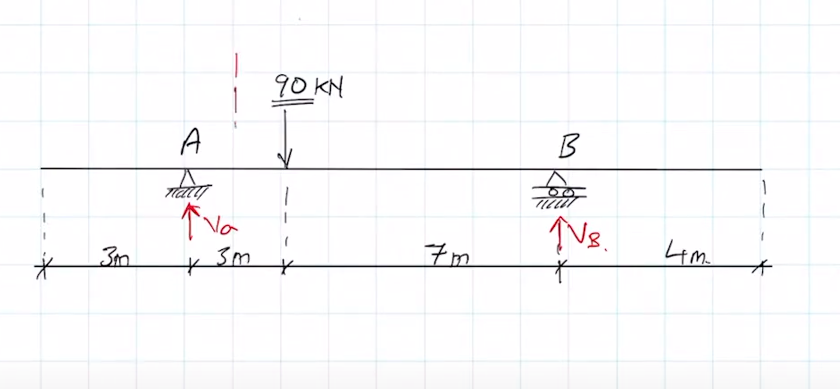

In [5]:
def reactions_PL(n):
    xp = pointLoads[n,0]#집중하중의 위치
    fx = pointLoads[n,1]#집중하중의 수평성분
    fy = pointLoads[n,2]#집중하중의 수직성분
    
    la_p = A-xp#토크
    mp = fy*la_p#모멘트
    la_vb = B-A#토크
    
    Vb = mp/la_vb#B지점의 수직반력
    Va = -fy-Vb#A지점의 수직반력
    Ha = -fx#A지점의 수평반력
    
    return Va,Vb,Ha
    

점모멘트에 의한 반력 계산

In [6]:
def reactions_PM(n):
    xm = pointMoments[n,0]
    m = pointMoments[n,1]
    la_vb = B-A
    
    Vb = m/la_vb
    Va = -Vb
    
    return Va, Vb

균일분포 계산

In [7]:
def reactions_UDL(n):
    xStart = distributedLoads[n,0]
    xEnd = distributedLoads[n,1]
    fy = distributedLoads[n,2]
    
    fy_Res = fy*(xEnd-xStart)
    x_Res = xStart + 0.5*(xEnd-xStart)
    
    la_p = A-x_Res
    mp = fy_Res*la_p
    la_vb = B-A
    
    Vb = mp/la_vb
    Va = -fy_Res-Vb
    
    return Va,Vb

In [8]:
def reactions_LDL(n):
    xStart = linearLoads[n,0]
    xEnd = linearLoads[n,1]
    fy_start = linearLoads[n,2]
    fy_end = linearLoads[n,3]
    
    if abs(fy_start)>0:
        fy_Res = 0.5 * fy_start*(xEnd-xStart)
        x_Res = xStart + (1/3)*(xEnd-xStart)
    else:
        fy_Res = 0.5*fy_end*(xEnd-xStart)
        x_Res = xStart + (2/3)*(xEnd-xStart)
            
    la_p = A-x_Res
    mp = fy_Res*la_p
    la_vb = B-A
    
    Vb = mp/la_vb
    Va = -fy_Res-Vb
    
    return Va,Vb
    

반력 계산

In [9]:
PL_record = np.empty([0,3])
if(nPL > 0):
    for n,p in enumerate(pointLoads):
        va,vb,ha = reactions_PL(n)
        PL_record = np.append(PL_record, [np.array([va,ha,vb])], axis=0) 
        #각 점에서 reaction 저장
        
        reactions[0] = reactions[0] + va
        reactions[1] = reactions[1] + ha
        reactions[2] = reactions[2] + vb
        

cycle 모든 점 모멘트

In [10]:
PM_record = np.empty([0,2])
if (nPM>0):
    for n,p in enumerate(pointMoments):
        va,vb = reactions_PM(n)
        PM_record = np.append(PM_record, [np.array([va,vb])], axis = 0)
        
        reactions[0] = reactions[0] + va
        reactions[2] = reactions[2] + vb

In [11]:
UDL_record = np.empty([0,2])
if (nUDL>0):
    for n,p in enumerate(distributedLoads):
        va,vb = reactions_UDL(n)
        UDL_record = np.append(UDL_record, [np.array([va,vb])], axis = 0)
        
        reactions[0] = reactions[0] + va
        reactions[2] = reactions[2] + vb

In [12]:
LDL_record = np.empty([0,2])
if (nLDL>0):
    for n,p in enumerate(linearLoads):
        va,vb = reactions_LDL(n)
        LDL_record = np.append(LDL_record, [np.array([va,vb])], axis = 0)
        
        reactions[0] = reactions[0] + va
        reactions[2] = reactions[2] + vb

## 전단응력도

x를 빔의 맨 왼쪽 기준 0이라 하고 오른쪽으로 이동하면서 그 거리를 x라고 할 경우. SFD는 총 4가지 CASE의 경우로 나눠야 함.

집중하중에 의해서 발생하는 전단응력과 모멘트 계산함수

In [13]:
def shear_moment_PL(n):
    xp = pointLoads[n,0]
    fy = pointLoads[n,2]
    Va = PL_record[n,0]
    Vb = PL_record[n,2]
    
    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))
    
    for i, x in enumerate(X):
        shear = 0
        moment = 0
        
        if x>A:
            shear = shear+Va
            moment = moment - Va*(x-A)
        if x>B:
            shear = shear+Vb
            moment = moment - Vb*(x-B)
        if x>xp:
            shear = shear+fy
            moment = moment - fy*(x-xp)
            
        Shear[i] = shear
        Moment[i] = moment
            
    return Shear,Moment
            

모든 집중 하중 관련

In [14]:
def shear_moment_PM(n):
    xm = pointLoads[n,0]
    m = pointLoads[n,1]
    Va = PM_record[n,0]
    Vb = PM_record[n,1]
    
    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))
    
    for i, x in enumerate(X):
        shear = 0
        moment = 0
        
        if x>A:
            shear = shear+Va
            moment = moment - Va*(x-A)
        if x>B:
            shear = shear+Vb
            moment = moment - Vb*(x-B)
        if x>xm:
            moment = moment - m
            
        Shear[i] = shear
        Moment[i] = moment
            
    return Shear,Moment

In [15]:
def shear_moment_UDL(n):
    
    xStart = distributedLoads[n,0]
    xEnd = distributedLoads[n,1]
    fy = distributedLoads[n,2]
    Va = UDL_record[n,0]
    Vb = UDL_record[n,1]
    
    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))
    
    for i, x in enumerate(X):
        shear = 0
        moment = 0
        
        if x>A:
            shear = shear+Va
            moment = moment - Va*(x-A)
        if x>B:
            shear = shear+Vb
            moment = moment - Vb*(x-B)
        if x>xStart and x<=xEnd:
            shear = shear+fy*(x-xStart)
            moment = moment - fy*(x-xStart)*0.5*(x-xStart)
        elif(x>xEnd):
            shear = shear + fy*(xEnd-xStart)
            moment = moment - fy*(xEnd-xStart)*(x-xStart*0.5*(x))
            
        Shear[i] = shear
        Moment[i] = moment
            
    return Shear,Moment
            

In [16]:
def shear_moment_LDL(n):
    
    xStart = linearLoads[n,0]
    xEnd = linearLoads[n,1]
    fy_start = linearLoads[n,2]
    fy_end = linearLoads[n,3]
    Va = LDL_record[n,0]
    Vb = LDL_record[n,1]
    
    Shear = np.zeros(len(X))
    Moment = np.zeros(len(X))
    
    for i, x in enumerate(X):
        shear = 0
        moment = 0
        
        if x>A:
            shear = shear+Va
            moment = moment - Va*(x-A)
        if x>B:
            shear = shear+Vb
            moment = moment - Vb*(x-B)
            
        if x>xStart and x<=xEnd:
            if abs(fy_start)>0:
                x_base = x-xStart
                f_cut = fy_start - x_base*(fy_start/(xEnd-xStart))
                R1 = 0.5 * x_base * (fy_start-f_cut)
                R2 = x_base * f_cut
                shear = shear + R1 + R2
                moment = moment - R1*(2/3)*x_base - R2 * (x_base/2)
            else:
                x_base = x-xStart
                f_cut = fy_start - x_base*(fy_start/(xEnd-xStart))
                R = 0.5 * x_base * f_cut
                shear = shear + R
                moment = moment - R*(x_base/3)
            
        elif(x>xEnd):
            if abs(fy_start>0):
                R = 0.5 * fy_end * (xEnd-xStart)
                xr = xStart + (1/3)*(xEnd-xStart)
                shear = shear+R
                moment = moment - R*(x-xr)
            else:
                R = 0.5 * fy_end * (xEnd-xStart)
                xr = xStart + (2/3)*(xEnd-xStart)
                shear = shear+R
                moment = moment - R*(x-xr)
            
        Shear[i] = shear
        Moment[i] = moment
            
    return Shear,Moment
            

In [17]:
if(nPL>0):
    for n,p in enumerate(pointLoads):
        Shear,Moment = shear_moment_PL(n)
        shearForce = np.append(shearForce, [Shear], axis = 0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

In [18]:
if(nPM>0):
    for n,p in enumerate(pointMoments):
        Shear,Moment = shear_moment_PL(n)
        shearForce = np.append(shearForce, [Shear], axis = 0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

In [19]:
if(nUDL>0):
    for n,p in enumerate(distributedLoads):
        Shear,Moment = shear_moment_UDL(n)
        shearForce = np.append(shearForce, [Shear], axis = 0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

In [20]:
if(nLDL>0):
    for n,p in enumerate(linearLoads):
        Shear,Moment = shear_moment_LDL(n)
        shearForce = np.append(shearForce, [Shear], axis = 0)
        bendingMoment = np.append(bendingMoment, [Moment], axis=0)

## 표현과 프린트

In [21]:
print('A에서의 수직 반력은 {one} kN'.format(one = round(reactions[0],2)))
print('B에서의 수직 반력은 {one} kN'.format(one = round(reactions[2],2)))
print('A에서의 수평 반력은 {one} kN'.format(one = round(reactions[1],2)))

A에서의 수직 반력은 71.5 kN
B에서의 수직 반력은 153.5 kN
A에서의 수평 반력은 0.0 kN


## PLOTLY

In [22]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

In [23]:
layout = go.Layout(
    title = {'text' : 'Shear Force Diagram', 
             'y':0.85,
             'x':0.5,
            'xanchor':'center',
            'yanchor':'top'},    
    yaxis = dict(
        title = 'Shear Force (kN)'
    ),
    xaxis = dict(
        title = 'Distance (m)',
        range = [-1, span+1]
    ),
    showlegend = False,
)


line = go.Scatter(
    x = X,
    y = sum(shearForce),
    mode = 'lines',
    name = 'Shear Force',
    fill = 'tonexty',
    line_color = 'green',
    fillcolor = 'rgba(0,255,0,0.1)'
)

axis = go.Scatter(
    x = [0,span],
    y = [0,0],
    mode = 'lines',
    line_color = 'black'
)

fig = go.Figure(data=[line,axis], layout = layout)

py.offline.iplot(fig)

In [24]:
layout = go.Layout(
    title = {'text' : 'Bending Moment Diagram', 
             'y':0.85,
             'x':0.5,
            'xanchor':'center',
            'yanchor':'top'},    
    yaxis = dict(
        title = 'Shear Force (kN)'
    ),
    xaxis = dict(
        title = 'Distance (m)',
        range = [-1, span+1]
    ),
    showlegend = False,
)


line = go.Scatter(
    x = X,
    y = sum(bendingMoment),
    mode = 'lines',
    name = 'Shear Force',
    fill = 'tonexty',
    line_color = 'green',
    fillcolor = 'rgba(0,255,0,0.1)'
)

axis = go.Scatter(
    x = [0,span],
    y = [0,0],
    mode = 'lines',
    line_color = 'black'
)

fig = go.Figure(data=[line,axis], layout = layout)

py.offline.iplot(fig)